# Demonstration of fitting models to ROC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models import HighThreshold, SignalDetection, DualProcess
from utils import plot_roc

## 1. Define the input data
This should be a set of response counts for each criterion level, for signal and for noise trials. The order matters and should range from the strongest "signal" response to the strongest "noise" response. In the below example, the task required confidence ratings of "high", "medium", and "low" to each stimulus, where stimuli could belong to one of two classes (signal, noise). The first three responses correspond to high, medium, and low confidence "signal" judgements; the final three correspond to low, medium, and high confidence "noise" judgements. The `signal` variable itself therefore contains all of the true positive responses (first three) and all of the false negative responses (final three). The `noise` variable contains all of the false positive (first three) and all of the true negative responses (final three). There is no restriction on the length of these arrays; they just need to be in the correct order.

In [2]:
# Strongest "signal" to strongest "noise" -->
signal = [505,248,226,172,144,93]
noise = [115,185,304,523,551,397]

## 2. Instantiate the model
There are 3 models defined `HighThreshold`, `SignalDetection`, and `DualProcess`. The `SignalDetection` can be initialised as the standard signal detection model with equal variances for the signal and noise distributions, or instead it can be initialised as the unequal variance signal detection model where the signal distribution variance is an additional parameter in the model, ranging from >= 1.

In [3]:
ht = HighThreshold(signal, noise)
evsd = SignalDetection(signal, noise, equal_variance=True)
uvsd = SignalDetection(signal, noise, equal_variance=False)
dpsd = DualProcess(signal, noise)

On initialisation we get a few things

In [4]:
print(f"Starting state of all parameters in the model: {evsd.initial_parameters}")
print(f"Accumulated counts arrays for signal and noise: {evsd.acc_signal}, {evsd.acc_noise}")
print(f"The accumulated counts in probability space (proportion signal & noise): {evsd.p_signal}, {evsd.p_noise}")
print(f"The z-transformed proportion arrays: {evsd.z_signal}, {evsd.z_noise}")
print(f"The area under the curve for the observed data: {evsd.auc}")

Starting state of all parameters in the model: {'d': 0, 'c0': 0, 'c1': 0, 'c2': 0, 'c3': 0, 'c4': 0}
Accumulated counts arrays for signal and noise: [ 505  753  979 1151 1295 1388], [ 115  300  604 1127 1678 2075]
The accumulated counts in probability space (proportion signal & noise): [0.3636909  0.54235661 0.70518359 0.82913367 0.93292537], [0.05547527 0.14466924 0.29118497 0.54319204 0.80868658]
The z-transformed proportion arrays: [-0.34861041  0.10637254  0.53936818  0.95074732  1.49793835], [-1.59393522 -1.05957395 -0.54992627  0.10847876  0.87306647]
The area under the curve for the observed data: 0.7439343243677308


## 3. Fitting the models
The models have been instantiated but are not yet fitted to the data. We can do this using $G^2$, $\chi^2$, or the $sse$ approach. It is recommended to use either the `'log-likelihood'` or `'chi'` methods. The legacy methods are pure scipy implementations.

In [5]:
evsd.fit('log-likelihood')
print(evsd.results)
print(evsd.fitted_parameters)

{'model': 'Equal Variance Signal Detection', 'opt-success': True, 'log-likelihood': 81.23108620009691, 'aic': -64.79662553538728, 'bic': -27.897282268972745, 'euclidean_fit': 0.10630270614413172}
{'d': 1.0201477503320475, 'criteria': array([ 0.94589746,  0.47680517,  0.01204214, -0.56213821, -1.28720453])}


In [6]:
evsd.fit('chi')
print(evsd.results)
print(evsd.fitted_parameters)

{'model': 'Equal Variance Signal Detection', 'opt-success': True, 'chi': 86.04650255112841, 'aic': -63.32723358721506, 'bic': -26.42789032080053, 'euclidean_fit': 0.11175639639965693}
{'d': 1.0031833005023736, 'criteria': array([ 0.93581744,  0.47496554,  0.01379012, -0.55634828, -1.2557949 ])}


In [7]:
evsd.fit('legacy log-likelihood')
print(evsd.results)
print(evsd.fitted_parameters)

{'model': 'Equal Variance Signal Detection', 'opt-success': True, 'legacy log-likelihood': 81.2310862004739, 'aic': -64.79662944841229, 'bic': -27.897286181997757, 'euclidean_fit': 0.10630271227204524}
{'d': 1.0201477995501629, 'criteria': array([ 0.94589751,  0.47680518,  0.01204218, -0.56213823, -1.28720449])}


In [8]:
evsd.fit('legacy pearson')
print(evsd.results)
print(evsd.fitted_parameters)

{'model': 'Equal Variance Signal Detection', 'opt-success': True, 'legacy pearson': 86.04650255124663, 'aic': -63.32723420657568, 'bic': -26.42789094016115, 'euclidean_fit': 0.11175639447331752}
{'d': 1.0031833109319939, 'criteria': array([ 0.93581744,  0.47496553,  0.01379012, -0.55634829, -1.2557949 ])}


In [9]:
evsd.fit('sse')
print(evsd.results)
print(evsd.fitted_parameters)

{'model': 'Equal Variance Signal Detection', 'opt-success': True, 'sse': 10675.578142610708, 'aic': -80.03261336494319, 'bic': -43.133270098528655, 'euclidean_fit': 0.08906582081110448}
{'d': 1.0781338726066931, 'criteria': array([ 0.92352889,  0.47140711,  0.00744258, -0.61995275, -1.39740717])}


In [10]:
evsd.results

{'model': 'Equal Variance Signal Detection',
 'opt-success': True,
 'sse': 10675.578142610708,
 'aic': -80.03261336494319,
 'bic': -43.133270098528655,
 'euclidean_fit': 0.08906582081110448}

Fit all of the models in a loop:

In [11]:
for model in [ht, evsd, uvsd, dpsd]:
    model.fit(method='log-likelihood')

## Visualise

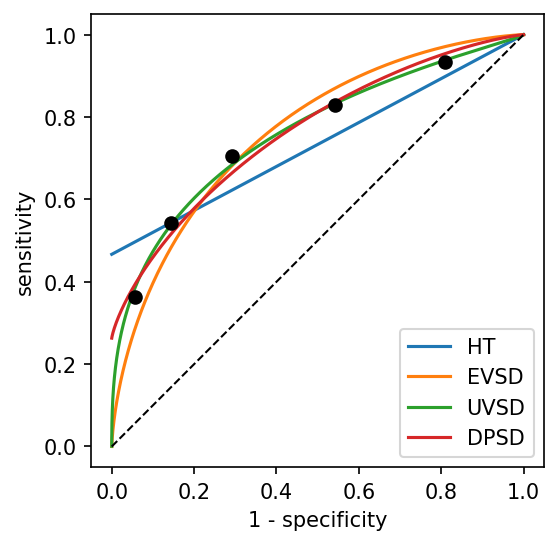

In [12]:
# Plot
fig, ax = plt.subplots(dpi=150)

# The result from `compute_expected` is a tuple of `expected_noise` and `expected_signal`.
# The `.fitted_parameters` attribute can be unpacked into that function for convenience.
ax.plot(*ht.compute_expected(**ht.fitted_named_parameters, full=True), label=ht.label)
ax.plot(*evsd.compute_expected(**evsd.fitted_named_parameters), label=evsd.label)
ax.plot(*uvsd.compute_expected(**uvsd.fitted_named_parameters), label=uvsd.label)
ax.plot(*dpsd.compute_expected(**dpsd.fitted_named_parameters), label=dpsd.label)

plot_roc(ht.p_signal, ht.p_noise, ax=ax, c='k', zorder=999)

ax.legend(loc='lower right')
plt.show()

## Comparing
We can compare using the statistic that was optimised for, in this case the $G^2$. However we can also view the AIC and BIC scores, both of which account for the number of parameters in the model.

In [13]:
# View the AIC scores for each model
Gs = {model.label: model.results['log-likelihood'] for model in [ht, evsd, uvsd, dpsd]}
AICs = {model.label: model.aic for model in [ht, evsd, uvsd, dpsd]}
BICs = {model.label: model.bic for model in [ht, evsd, uvsd, dpsd]}
print(Gs, AICs, BICs, sep="\n")

{'HT': 205.34283382645697, 'EVSD': 81.23108620009691, 'UVSD': 3.902024727392697, 'DPSD': 23.17123947088581}
{'HT': -29.97962879225225, 'EVSD': -64.79662553538728, 'UVSD': -98.43321886926276, 'DPSD': -76.4583993130579}
{'HT': -17.679847703447404, 'EVSD': -27.897282268972745, 'UVSD': -55.3839850584458, 'DPSD': -33.40916550224094}


From the $G^2$ values, we can also perform a significance test from the comparison, accounting for the degrees of freedom. For example, comparing the equal and unequal variance signal detection models, we can do the following:

In [48]:
# Get the G^2 values and their difference
g2diff = evsd.results['log-likelihood'] - uvsd.results['log-likelihood']
# Get the difference in the degrees of freedom for each model
ddofdiff = evsd.ddof - uvsd.ddof

p = stats.chi2.sf(x=g2diff, df=ddofdiff)
print("p = ", p)

p =  0.0026558448161220316
